# Creating a Successful Movie Studio

**Author:** Seth Schober

## Overview
*** ***
[one paragraph overview of the project, including the business problem, data, methods, results and recommendations]

## Business Problem

*** ***
Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?

## Data Understanding

*** ***
Describe the data being used for this project.

Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?

Also define basic acronyms used throughout (e.g. rt=rotten tomatoes)

## Data Preparation



*** ***
Describe and justify the process for preparing the data for analysis.

Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?

*** ***

**Import standard packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf
import statistics

pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

**Import the data to be used for this project from external CSV files in *data* directory**

In [2]:
# basic film data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# film review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# basic film data from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# film review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# full dataset from TMDb (The Movie Database)
# largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

# top director metrics from The Numbers
path = os.path.join('data', 'tn.top_directors.csv')
tn_top_directors = pd.read_csv(path, encoding= 'unicode_escape') 
# source: https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director

**Basic data cleaning necessary for remainder of analysis**

In [3]:
# Clean data from Rotten Tomatoes
# external csv files contain a simple map between current data and
# reformatted data that can be used later in the analysis

# import Studio cleaning dictionary
path = os.path.join('cleaning_dicts','rt_studios.csv')
df = pd.read_csv(path)
studio_cleanup = dict(zip(df.old, df.new))

# import Ratings cleaning dictionary
path = os.path.join('cleaning_dicts','rt_ratings.csv')
df = pd.read_csv(path)
rating_cleanup = dict(zip(df.old, df.new))


path = os.path.join('cleaning_dicts','rt_directors.csv')
df = pd.read_csv(path)
director_cleanup = dict(zip(df.old, df.new))


# apply cleaning dictionary and drop unused columns
rt_reviews['rating'] = rt_reviews['rating'].map(rating_cleanup)
rt_movie_info['studio'] = rt_movie_info['studio'].map(studio_cleanup).fillna(rt_movie_info['studio'])


# convert Fresh/Rotten column to binary 1/0 (i.e. good/bad)
rt_reviews['fresh'] = rt_reviews['fresh'].map({'fresh':1, 'rotten':0})

# converts "None" values/types to NaN for easier manipulation later
imdb_title_basics.fillna(value=np.nan, inplace=True)
imdb_title_ratings.fillna(value=np.nan, inplace=True)
tmdb_movies.fillna(value=np.nan, inplace=True)
tn_movie_budgets.fillna(value=np.nan, inplace=True)
rt_movie_info.fillna(value=np.nan, inplace=True)
rt_reviews.fillna(value=np.nan, inplace=True)

In [4]:
# Drop unused columns for simplicity downstream

rt_movie_info.drop(['synopsis', 'runtime', 'rating', 'dvd_date', 
                    'currency', 'rating', 'theater_date', 'writer'], 
                     axis=1, inplace=True)

rt_reviews.drop(['review', 'publisher', 'critic', 'top_critic', 'date'], 
                axis=1, inplace=True)

imdb_title_basics.drop(['original_title', 'start_year', 'runtime_minutes']
                       , axis=1, inplace=True)

tmdb_movies.drop(['Unnamed: 0', 'original_title', 'id', 
                  'original_language', 'genre_ids', 'vote_average',
                  'vote_count', 'release_date'], axis=1, inplace=True)

tn_movie_budgets.drop(['id', 'release_date'], axis=1, inplace=True)

**Clean financial data**

In [5]:
# All relevant financial data is stored in The Numbers database
# rename to make analysis easier to follow
finance = tn_movie_budgets.copy()


# for numbers: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',',''))
                     for x in finance['production_budget']] 
domestic_gross = [float(x.replace('$', '').replace(',','')) 
                  for x in finance['domestic_gross']]
worldwide_gross = [float(x.replace('$', '').replace(',','')) 
                   for x in finance['worldwide_gross']]


# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [6]:
finance['profit'].mean() # THIS DOESN'T CHANGE IRREGULARLY
finance

,movie,production_budget,domestic_gross,worldwide_gross,profit
0,Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08
...,...,...,...,...,...
5777,Red 11,7000.0,0.0,0.000000e+00,-7.000000e+03
5778,Following,6000.0,48482.0,2.404950e+05,2.344950e+05
5779,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,-3.662000e+03
5780,A Plague So Pleasant,1400.0,0.0,0.000000e+00,-1.400000e+03


**Clean Genre data**

In [7]:
# The original formatting of genre data shows multiple genres  
# in each genre cell for selected movies (corresponding to 
# movies classified in multiple genres). The are separated by 
# commas. The below analysis instead creates a distinct column
# for each genre and represents the data as binary 1 or 0 to 
# indicate whether a given film is classified within that genre.

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []

for g in genres_messy:
    for g_split in g.split(','):
        genres_clean.append(g_split)

# remove duplicates
genres_clean = list(set(genres_clean))
genres_clean.sort()


#create dataframe containing only genre data for each film
df = imdb_title_basics
binary_genres = df.loc[df['genres'].isna() == False].copy()

# create a column for each genre
# assign a binary 1/0 for the film's genre classification
for col in genres_clean:
    binary_genres[col] = [col in x for x in binary_genres['genres']]

In [8]:
pd.DataFrame(genres_messy).to_csv(r'data/genres_messy_try4.csv') 

In [9]:
binary_genres.to_csv(r'data/binary_genres_try8.csv') 
#INCONSISTENT EVERY TIME!

*** ***

**Aggregate data to create one DataFrame containing everything used in the remainder of the analysis**

In [10]:
# Use SQL to join sources of data to create cohesive and
# comprehensive dataset

# renaming now makes the SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})

# write query
q = ''' SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN binary_genres USING (tconst);'''

# Use SQL to join relevant dataframes
all_data = pysqldf(q)
all_data.drop(['primary_title', 'genres'], axis=1, inplace=True)

In [11]:
path = os.path.join('data','all_data.csv')
all_data.to_csv(r'data/all_data.csv') 

#INCONSISTENT EVERY TIME!

## Data Analysis Phase 1: The Impact of Genre

[DESCRIPTION HERE OF STEPS TO COME]

### Data breakdown by Genre to gain an understanding of how film performance varies across genres

Start with creating an empty dataframe.

Note that the mean is used for popularity metrics given that they are on a 10-point scale, thus eliminating the possibility of outliers. The median is used in areas where outliers are prevalent.

In [12]:
# Create dataframe as the base for aggregating data 
# on a per-genre basis into one dataframe

df_genres = pd.DataFrame(genres_clean)
df_genres.columns = ['genre']
df_genres.sort_values(by='genre', inplace=True)
df_genres.reset_index(inplace=True, drop=True)

In [13]:
df_genres # DOES NOT CHANGE IRREGULARLY

,genre
0,Action
1,Adult
2,Adventure
3,Animation
4,Biography
5,Comedy
6,Crime
7,Documentary
8,Drama
9,Family


**Add financial performance data**

In [14]:
# Calculate the mean and median profit for each genre
profit_median = []
profit_mean = []
for g in genres_clean:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
     
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean

# Add column to rank the median profit of each genre
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)

In [15]:
df_genres.sort_values(by='genre')

,genre,profit_median,profit_mean,profit_rank
0,Action,25023759.0,1.097484e+08,6
1,Adult,NaN,NaN,23
2,Adventure,57375039.0,1.904184e+08,2
3,Animation,85294313.5,1.940365e+08,0
4,Biography,9876855.0,4.926510e+07,12
5,Comedy,15275343.5,7.148983e+07,8
6,Crime,2434356.0,3.733343e+07,20
7,Documentary,7685268.0,5.307152e+07,14
8,Drama,4797192.0,4.173338e+07,17
9,Family,36627518.0,1.283730e+08,4


**Add popularity metrics**

In [16]:
# Calculate the mean and median popularity for each genre
pop_median = []
pop_mean = []
for g in genres_clean:
    pop = all_data.loc[(all_data['popularity'].isna() == False) &
                       (all_data[g] == True), 'popularity']
    pop_median.append(pop.median())
    pop_mean.append(pop.mean())
    
df_genres['popularity_median'] = pop_median
df_genres['popularity_mean'] = pop_mean


# Add column to rank the median popularity of each genre
df_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)

**Add metric for the number of movies in each genre**

In [17]:
# Calculate the total number of movies belonging to each genre
movie_ct = []
for g in genres_clean:
    ct = all_data.loc[(all_data[g] == True), g]
    movie_ct.append(ct.sum())

# add column with count data
df_genres['movie_ct'] = movie_ct
df_genres.dropna(inplace=True)

**Remove genres that have very few movies, as it is an indicator of an overall small demand for films in that genre**

In [18]:
MIN_MOVIE_CT = 2000

df_genres = df_genres.loc[df_genres['movie_ct'] > MIN_MOVIE_CT].copy()
df_genres.sort_values(by='movie_ct', inplace=True)

In [19]:
df_genres.sort_values(by='genre')

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
0,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,25948.0
2,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,0,10806.0
3,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
4,Biography,9876855.0,4.926510e+07,12,1.4000,3.712482,16,4940.0
5,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,13,11427.0
6,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0
8,Drama,4797192.0,4.173338e+07,17,0.6600,1.733840,24,12754.0
9,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,10,3682.0
12,History,11507410.0,5.656655e+07,11,3.9030,3.897000,14,5755.0
13,Horror,6898293.0,4.563700e+07,15,1.2375,4.587429,7,52537.0


**Determine the most successful genres overall**

Consider both profitability and popularity to determine which genres are most lucrative. 

In [20]:
# From the start, exclude movies that are relatively poorly
# ranked in terms of profit or popularity.

# These numbers are based on a close, manual analysis of the 
# data. Future studies will use statistical methods instead. 
min_profitrank = 20
min_poprank = 20
num_to_include_in_leaders = 4

leading_genres = df_genres.loc[(df_genres['profit_rank'] <= min_profitrank)].copy()
leading_genres = df_genres.loc[(df_genres['popularity_rank'] <= min_poprank)].copy()
leading_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)
leading_genres = leading_genres.iloc[:num_to_include_in_leaders].copy()

In [21]:
# Isolate the genres that are *not* leaders

trailing_genres = df_genres.copy()

for g in list(df_genres['genre']):
    if g in list(leading_genres['genre']):
        x = df_genres.loc[df_genres.genre == g].index
        trailing_genres.drop(index=x, inplace=True)

# Use the below analysis to determine an aggregate
# valuation of genres that are *not* in the top performers
# as a means of comparison

pop_agg = []
profit_agg = []
ct = 0

for g in list(trailing_genres['genre']):
    pop = all_data.loc[(all_data['popularity'].isna() == False) & 
                       (all_data[g] == True), 'popularity']
    pop_agg.append(list(pop))

    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_agg.append(list(profit))

    ct += len(all_data.loc[(all_data['tconst'].isna() == False) & 
                           (all_data[g] == True), 'tconst'])

# currently formatted as lists of lists. Make into one list instead,
# then calculate key metrics
profit_flat = [val for sublist in profit_agg for val in sublist]
profit_median = statistics.median(profit_flat)
profit_mean = statistics.mean(profit_flat)
    
# currently formatted as lists of lists. Make into one list instead,
# then calculate key metrics    
pop_flat = [val for sublist in pop_agg for val in sublist]
pop_median = statistics.median(pop_flat)
pop_mean = statistics.mean(pop_flat)
rank = leading_genres.profit_rank.max() + 1

# add an "All Others" category to be plotted alongside top performers
leading_genres = leading_genres.append({'genre': 'All Others',
                       'profit_median': profit_median,
                       'profit_mean': profit_mean,
                       'profit_rank': rank,
                       'popularity_median': pop_median,
                       'popularity_mean':pop_mean,
                       'popularity_rank':rank,
                       'movie_ct': ct}, ignore_index=True)

In [22]:
leading_genres.sort_values(by='popularity_mean')

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
4,All Others,10332380.5,6.251144e+07,21,2.0380,4.241511,21,146129.0
3,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0
2,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
1,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,2,6737.0
0,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,0,10806.0


In [23]:
all_data['popularity'].mean() # THIS DOESN'T CHANGE IRREGULARLY

3.8539302181459223

In [24]:
df_genres # EVERY PART OF THIS CHANGES IRREGULARLY

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
3,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,2906.0
24,Thriller,4299670.0,4.964393e+07,18,0.6970,3.243200,20,3571.0
9,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,10,3682.0
4,Biography,9876855.0,4.926510e+07,12,1.4000,3.712482,16,4940.0
12,History,11507410.0,5.656655e+07,11,3.9030,3.897000,14,5755.0
22,Sport,3253717.5,6.474102e+07,19,2.3790,4.282739,9,6462.0
19,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,2,6737.0
25,War,4856688.0,3.903443e+07,16,2.5520,4.599446,6,7132.0
6,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,4,8990.0
14,Music,8462398.0,1.288383e+08,13,1.9530,3.630725,19,9765.0


### Plot findings: how do the genres compare?

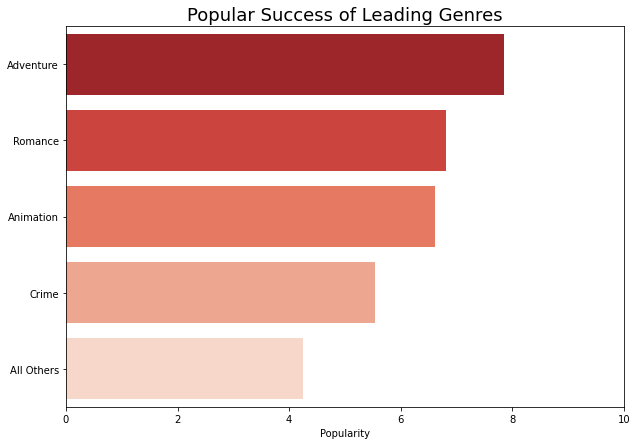

In [25]:
leading_genres.sort_values(by='popularity_mean', 
                           ascending=False, inplace=True)


x = leading_genres['genre']
y = leading_genres['popularity_mean']

f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
sns.set_context('talk') 
sns.set_palette("Reds_r")
sns.barplot(data = leading_genres, 
            y = 'genre', 
            x = 'popularity_mean', 
            ax=ax, 
            palette='Reds_r', orient='h')
plt.ylabel('')
plt.xlabel('Popularity')
ax.set(xlim=(0,10))
ax.set_title('Popular Success of Leading Genres')
plt.savefig('images/Popular Success of Leading Genres.png')
plt.show()

### Now that we know what is popular, how does popularity affect the profitability of a film?

Text(0.5, 1.0, 'Correlation between popularity and profit')

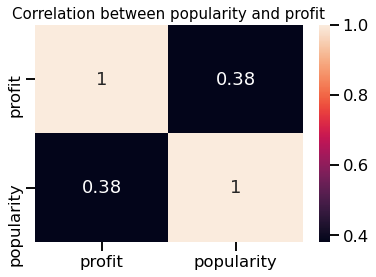

In [26]:
# This portion of the analysis takes a subset of the full movie database,
# specifically, those within the target genres, and investigates the
# relationship between profitability and popularity.

# Create a dataframe based off the full dataset
df = all_data.dropna().copy()

# Gather lists of the profit and popularity values for every
# film within the leading genres
prof = []
pop = []
for g in list(leading_genres.genre):
    if g == 'All Others':
        pass
    else:
        x = df.loc[df[g]==True]
        prof.append(list(x['profit']))
        pop.append(list(x['popularity']))

        
# currently formatted as lists of lists. Make each pop and prof
# into their own single-layer lists instead
prof_flat = [val for sublist in prof for val in sublist]
pop_flat = [val for sublist in pop for val in sublist]

 
# remove profit outliers by calculating the std dev and median
profit_std = statistics.pstdev(prof_flat)
profit_med = statistics.median(prof_flat)
profit_lo = profit_med - 3 * profit_std
profit_hi = profit_med + 3 * profit_std
prof_outlier = df.loc[(df['profit'] > profit_hi) | 
            (df['profit'] < profit_lo)]

# remove popularity outliers by calculating the std dev and median
pop_std = statistics.pstdev(pop_flat)
pop_med = statistics.median(pop_flat)
pop_lo = pop_med - 3 * pop_std
pop_hi = pop_med + 3 * pop_std
pop_outlier = df.loc[(df['popularity'] > pop_hi) | 
            (df['popularity'] < pop_lo)]

# remove outliers from the dataset
df = df.drop(pop_outlier.index.append(prof_outlier.index)).copy()
df = df[['profit', 'popularity']].copy()

# plot
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between popularity and profit", fontsize=15)

**Plot the relationship between popularity and profitability for the selected leading genres**

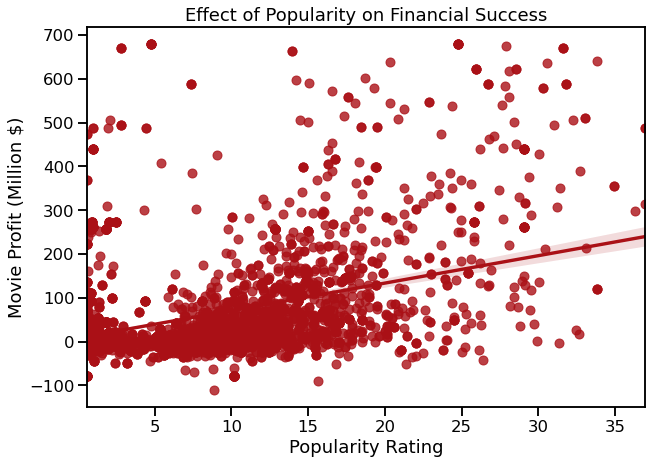

In [27]:
# declare dataset
x = df['popularity']
y = df['profit']/10**6

#set themes and create figure
sns.set_context('talk') 
sns.set_palette("Reds_r")
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

# downsample data to make scatterplot easier to visually interpret
dfSample = df.sample(2800)
xdataSample, ydataSample = x,y#dfSample["popularity"], dfSample["profit"]



# produce plot
sns.regplot(x=xdataSample, y=ydataSample, ax=ax) 
plt.xlabel('Popularity Rating')
plt.ylabel('Movie Profit (Million $)')
ax.set_title('Effect of Popularity on Financial Success')
plt.savefig('images/Effect of Popularity on Financial Success.png')
plt.show()

## Analysis Phase 2: The Impact of the Director

[Describe what's going on here]

**Additional cleaning of rotten tomatoes datasets.**

In [28]:
##### CALCULATE THE AVERAGE 'FRESH' RATING FOR EACH MOVIE ID
MINIMUM_FRESHOMETER = 5 #minimum number of reviews to be considered


freshness = pd.DataFrame([rt_reviews.id.unique()], index=['id']).transpose()
rating = pd.DataFrame([rt_reviews.id.unique()], index=['id']).transpose()

for movie_id in freshness['id']:
    fresh =  rt_reviews.loc[rt_reviews['id'] == movie_id, 'fresh']
    rating = rt_reviews.loc[rt_reviews['id'] == movie_id, 'rating']

    review_ct = rt_reviews.loc[rt_reviews['id'] == movie_id, 'fresh'].size
    if  review_ct >= MINIMUM_FRESHOMETER:
        freshness.loc[freshness['id'] == movie_id, 'fresh'] = fresh.mean() 
        freshness.loc[freshness['id'] == movie_id, 'rating'] = rating.mean()

freshness = freshness.dropna()

**[DESCRIPTION]**

In [29]:
# --- CORRELATION BETWEEN TWO POPULARITY METRICS ---
rt = pysqldf(''' 
SELECT * FROM rt_movie_info
LEFT JOIN freshness USING (id);''')


# if not already a float, remove ',' and convert to float
clean = []
for x in rt['box_office']:
    if type(x) == type('abc'):
        clean.append(float(x.replace(',','')))
    else:
        clean.append(x)

# update column in dataframe with floats
rt['box_office'] = clean

In [30]:
rt

,id,genre,director,box_office,studio,fresh,rating
0,1,Action and Adventure|Classics|Drama,William Friedkin,NaN,None,NaN,NaN
1,3,Drama|Science Fiction and Fantasy,David Cronenberg,600000.0,Entertainment One,0.631902,5.988938
2,5,Drama|Musical and Performing Arts,Allison Anders,NaN,None,0.782609,6.800000
3,6,Drama|Mystery and Suspense,Barry Levinson,NaN,None,0.561404,5.890244
4,7,Drama|Romance,Rodney Bennett,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...
1555,1996,Action and Adventure|Horror|Mystery and Suspense,None,33886034.0,New Line Cinema,0.671329,6.047113
1556,1997,Comedy|Science Fiction and Fantasy,Steve Barron,NaN,Paramount,0.357143,4.587091
1557,1998,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,None,NaN,NaN
1558,1999,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,NaN,None,0.586957,5.854839


**Aggregate data for each director**

In [31]:
# In many cases, there are multiple directors. This loop is 
# necessary to split the string into each director separately

# the 'counts' values correspond to the number of films directed
# by the corresponding director
director_counts_dict = {}
directors = rt['director'].loc[rt['director'].isna()==False]
for name in directors:
    for name_split in name.split(sep = '|'):
        if name_split in director_counts_dict.keys():
            director_counts_dict[name_split] += 1
        else:
            director_counts_dict[name_split] = 1

director_counts_df = pd.Series(director_counts_dict).sort_values(ascending=False)

**Compare the performance of each director to identify the top performers**

In [32]:
tn_top_directors

,rank,name,worldwide_box_office,movies,average
0,1,Steven Spielberg,10548165432,36,293004595
1,2,Anthony Russo,6839063507,7,977009072
2,3,Joe Russo,6839063507,8,854882938
3,4,Peter Jackson,6535735207,14,466838229
4,5,Michael Bay,6443668115,16,402729257
...,...,...,...,...,...
995,996,Park Chan-wook,94017407,8,11752176
996,997,Bronwen Hughes,93957800,2,46978900
997,998,Bob Fosse,93623112,4,23405778
998,999,Mike Binder,93561782,8,11695223


In [33]:
# the copied dataframe contains a list of the top 1000 directors
# as provided by The Numbers
top_directors = tn_top_directors.copy()


# only producers with production +1stddev from median performance
# as this is an indicator of a bredth of experience relative to peers
movies = top_directors.movies
min_movies_to_qualify = movies.std() + movies.median()

# when recommending a top director, it is important 
# that they aren't dead or 'out of service'. This is a manually
# compiled list of directors who appeared at the
# top of the list but who cannot be recommended
OUT_OF_SERVICE = ['Clint Eastwood']

for i, director in enumerate(OUT_OF_SERVICE):
    index_director = top_directors.loc[top_directors.name==OUT_OF_SERVICE[i]].index
    top_directors.drop(index=index_director, inplace=True)

top_directors = top_directors.loc[top_directors['movies'] > min_movies_to_qualify]

# rank the directors into four tiers
# the number assigned to each bucket is less relevant as the
# goal is to show an overall trend
t1 = 5
t2 = 25
t3 = 50
t4 = 100

# place each director into tier 1-4
# based on their worldwide_box_office after having 
# filtered out directors to include those with higher # of films
# directed (i.e. not 'one hit wonders')
tier1 = top_directors.iloc[0: t1]['average'].median()/10**6
tier2 = top_directors.iloc[t1: t2]['average'].median()/10**6
tier3 = top_directors.iloc[t2: t3]['average'].median()/10**6
tier4 = top_directors.iloc[t3:]['average'].median()/10**6

**Plot Findings**

,Top 5 Directors
1,Steven Spielberg
2,Peter Jackson
3,Michael Bay
4,James Cameron
5,Christopher Nolan


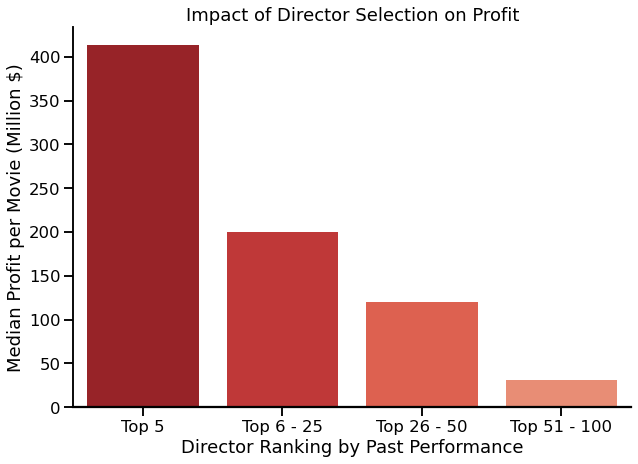

In [34]:
sns.set_context('talk') 
palette = sns.color_palette("Reds_r")
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = [f'Top {t1}', 
     f'Top {t1+1} - {t2}', 
     f'Top {t2+1} - {t3}', 
     f'Top {t3+1} - {t4}']
y = [tier1, tier2, tier3, tier4]

sns.barplot(x=x, y=y, ax=ax, palette=palette)
ax.axhline(0, color="k", clip_on=False)
ax.set_xlabel('Director Ranking by Past Performance')
ax.set_ylabel("Median Profit per Movie (Million $)")
ax.set_title('Impact of Director Selection on Profit')
sns.despine(bottom=True)
plt.savefig('images/Impact of Director Selection on Profit.png')


ct = 5
table = top_directors[['name']].iloc[:ct]
table.index = range(1,ct+1)
table.columns = [f'Top {ct} Directors']
table

# Investigation Evaluation

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***